In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    batch_size, batch_height, batch_width = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [4]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #print(src_i, src_j, src_k)
    #print(tgt_i, tgt_j, tgt_k)
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        t.logical_and(
            greater_zero_mask,
            t.logical_and(unequal_mask, sml_eq_two_mask)
        )
    )
    
    #print(vol_changes[update_mask])
    #print(adjusted_vols[update_mask])
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [5]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    grad = t.autograd.grad(mean_distance, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance

In [6]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

# Num_steps = 40, 8x8 grid

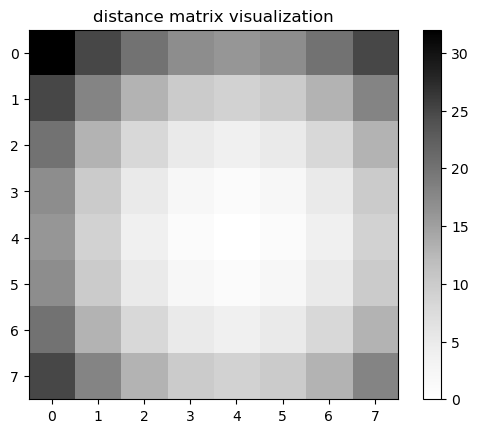

In [7]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, 8x8 grid

In [8]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v0 = []
mean_distances_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 52.84it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 53.12it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 6.583473134593834e-29


100%|██████████| 40/40 [00:00<00:00, 49.58it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 5.189715302465758e-13


100%|██████████| 40/40 [00:00<00:00, 58.38it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: 7.004782531794262e-08


100%|██████████| 40/40 [00:00<00:00, 60.95it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: 0.0002549301425460726


100%|██████████| 40/40 [00:00<00:00, 58.46it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: 0.0011422553798183799


100%|██████████| 40/40 [00:00<00:00, 60.13it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: 0.005550670437514782


100%|██████████| 40/40 [00:00<00:00, 58.64it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: 0.03495608642697334


100%|██████████| 40/40 [00:00<00:00, 59.15it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: 0.08822650462388992


100%|██████████| 40/40 [00:00<00:00, 59.86it/s]


temperature: 0.4736842215061188, mean distance: 0.0
gradient: 0.11525878310203552


100%|██████████| 40/40 [00:00<00:00, 55.32it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: 0.23624750971794128


100%|██████████| 40/40 [00:00<00:00, 50.83it/s]


temperature: 0.5789473652839661, mean distance: 0.0
gradient: 0.2872130572795868


100%|██████████| 40/40 [00:00<00:00, 50.01it/s]


temperature: 0.6315789222717285, mean distance: 0.0
gradient: 0.44081228971481323


100%|██████████| 40/40 [00:00<00:00, 51.62it/s]


temperature: 0.6842105388641357, mean distance: 0.020000000000000004
gradient: 0.5496708750724792


100%|██████████| 40/40 [00:00<00:00, 58.04it/s]


temperature: 0.7368420958518982, mean distance: 0.04000000000000001
gradient: 0.5425016283988953


100%|██████████| 40/40 [00:00<00:00, 59.77it/s]


temperature: 0.7894736528396606, mean distance: 0.030000000000000006
gradient: 0.6180697679519653


100%|██████████| 40/40 [00:00<00:00, 48.73it/s]


temperature: 0.8421052694320679, mean distance: 0.05000000000000001
gradient: 0.6716755032539368


100%|██████████| 40/40 [00:00<00:00, 50.20it/s]


temperature: 0.8947368264198303, mean distance: 0.05000000000000001
gradient: 0.785836398601532


100%|██████████| 40/40 [00:00<00:00, 55.70it/s]


temperature: 0.9473684430122375, mean distance: 0.015000000000000003
gradient: 0.9103599786758423


100%|██████████| 40/40 [00:00<00:00, 56.97it/s]


temperature: 1.0, mean distance: 0.095
gradient: 0.7978842854499817


100%|██████████| 40/40 [00:00<00:00, 59.59it/s]


temperature: 1.0, mean distance: 0.02
gradient: 0.7753469347953796


100%|██████████| 40/40 [00:00<00:00, 54.13it/s]


temperature: 2.0, mean distance: 0.295
gradient: 0.3678070604801178


100%|██████████| 40/40 [00:00<00:00, 55.94it/s]


temperature: 3.0, mean distance: 0.465
gradient: 0.13785673677921295


100%|██████████| 40/40 [00:00<00:00, 55.09it/s]


temperature: 4.0, mean distance: 0.61
gradient: 0.05742661654949188


100%|██████████| 40/40 [00:00<00:00, 51.42it/s]


temperature: 5.0, mean distance: 0.595
gradient: 0.04900801554322243


100%|██████████| 40/40 [00:00<00:00, 50.70it/s]


temperature: 6.0, mean distance: 0.725
gradient: 0.025465544313192368


100%|██████████| 40/40 [00:00<00:00, 46.42it/s]


temperature: 7.0, mean distance: 0.71
gradient: 0.02163238823413849


100%|██████████| 40/40 [00:01<00:00, 39.55it/s]


temperature: 8.0, mean distance: 0.665
gradient: 0.017371779307723045


100%|██████████| 40/40 [00:00<00:00, 44.66it/s]


temperature: 9.0, mean distance: 0.65
gradient: 0.014828566461801529


100%|██████████| 40/40 [00:00<00:00, 49.58it/s]


temperature: 10.0, mean distance: 0.695
gradient: 0.009393475018441677


100%|██████████| 40/40 [00:00<00:00, 45.32it/s]


temperature: 11.0, mean distance: 0.745
gradient: 0.00962960347533226


100%|██████████| 40/40 [00:00<00:00, 45.99it/s]


temperature: 12.0, mean distance: 0.745
gradient: 0.005631706677377224


100%|██████████| 40/40 [00:00<00:00, 46.42it/s]


temperature: 13.0, mean distance: 0.705
gradient: 0.005371908191591501


100%|██████████| 40/40 [00:00<00:00, 48.38it/s]


temperature: 14.0, mean distance: 0.745
gradient: 0.005580215714871883


100%|██████████| 40/40 [00:00<00:00, 42.90it/s]


temperature: 15.0, mean distance: 0.705
gradient: 0.004632655996829271


100%|██████████| 40/40 [00:00<00:00, 44.81it/s]


temperature: 16.0, mean distance: 0.715
gradient: 0.004580547567456961


100%|██████████| 40/40 [00:00<00:00, 46.10it/s]


temperature: 17.0, mean distance: 0.69
gradient: 0.004183452110737562


100%|██████████| 40/40 [00:00<00:00, 49.33it/s]


temperature: 18.0, mean distance: 0.77
gradient: 0.003766746958717704


100%|██████████| 40/40 [00:00<00:00, 51.16it/s]


temperature: 19.0, mean distance: 0.72
gradient: 0.0035372867714613676


100%|██████████| 40/40 [00:00<00:00, 48.91it/s]


temperature: 20.0, mean distance: 0.74
gradient: 0.003394616534933448


100%|██████████| 40/40 [00:00<00:00, 51.09it/s]


temperature: 21.0, mean distance: 0.74
gradient: 0.0026633720844984055


100%|██████████| 40/40 [00:00<00:00, 53.33it/s]


temperature: 22.0, mean distance: 0.685
gradient: 0.0024297325871884823


100%|██████████| 40/40 [00:00<00:00, 50.64it/s]


temperature: 23.0, mean distance: 0.71
gradient: 0.0025871118996292353


100%|██████████| 40/40 [00:00<00:00, 48.97it/s]


temperature: 24.0, mean distance: 0.745
gradient: 0.0024212116841226816


100%|██████████| 40/40 [00:00<00:00, 50.32it/s]

temperature: 25.0, mean distance: 0.75
gradient: 0.002706326777115464


target_vol = 1, 8x8 grid

In [10]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v1 = []
mean_distances_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())

100%|██████████| 40/40 [00:01<00:00, 39.91it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 46.37it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 7.873307913541794e-05


100%|██████████| 40/40 [00:00<00:00, 44.07it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 0.22441959381103516


100%|██████████| 40/40 [00:00<00:00, 50.90it/s]


temperature: 0.15789473056793213, mean distance: 0.015000000000000003
gradient: 1.6269031763076782


100%|██████████| 40/40 [00:00<00:00, 56.89it/s]


temperature: 0.21052631735801697, mean distance: 0.05000000000000001
gradient: 1.8892508745193481


100%|██████████| 40/40 [00:00<00:00, 50.13it/s]


temperature: 0.2631579041481018, mean distance: 0.10000000000000002
gradient: 2.456958055496216


100%|██████████| 40/40 [00:00<00:00, 53.69it/s]


temperature: 0.31578946113586426, mean distance: 0.13
gradient: 1.816165804862976


100%|██████████| 40/40 [00:00<00:00, 56.97it/s]


temperature: 0.3684210479259491, mean distance: 0.14500000000000002
gradient: 1.7346735000610352


100%|██████████| 40/40 [00:00<00:00, 58.13it/s]


temperature: 0.42105263471603394, mean distance: 0.195
gradient: 1.4641954898834229


100%|██████████| 40/40 [00:00<00:00, 56.89it/s]


temperature: 0.4736842215061188, mean distance: 0.32
gradient: 1.095205307006836


100%|██████████| 40/40 [00:00<00:00, 57.30it/s]


temperature: 0.5263158082962036, mean distance: 0.39
gradient: 0.8153907060623169


100%|██████████| 40/40 [00:00<00:00, 54.42it/s]


temperature: 0.5789473652839661, mean distance: 0.42
gradient: 0.6905016303062439


100%|██████████| 40/40 [00:00<00:00, 48.67it/s]


temperature: 0.6315789222717285, mean distance: 0.53
gradient: 0.5434123873710632


100%|██████████| 40/40 [00:00<00:00, 41.82it/s]


temperature: 0.6842105388641357, mean distance: 0.5100000000000001
gradient: 0.49014052748680115


100%|██████████| 40/40 [00:00<00:00, 49.58it/s]


temperature: 0.7368420958518982, mean distance: 0.5
gradient: 0.4230142831802368


100%|██████████| 40/40 [00:00<00:00, 53.55it/s]


temperature: 0.7894736528396606, mean distance: 0.525
gradient: 0.40902647376060486


100%|██████████| 40/40 [00:00<00:00, 51.35it/s]


temperature: 0.8421052694320679, mean distance: 0.555
gradient: 0.339273601770401


100%|██████████| 40/40 [00:00<00:00, 49.33it/s]


temperature: 0.8947368264198303, mean distance: 0.5900000000000001
gradient: 0.26851722598075867


100%|██████████| 40/40 [00:00<00:00, 53.19it/s]


temperature: 0.9473684430122375, mean distance: 0.635
gradient: 0.222914919257164


100%|██████████| 40/40 [00:00<00:00, 52.29it/s]


temperature: 1.0, mean distance: 0.6
gradient: 0.19713282585144043


100%|██████████| 40/40 [00:00<00:00, 51.95it/s]


temperature: 1.0, mean distance: 0.65
gradient: 0.19388113915920258


100%|██████████| 40/40 [00:00<00:00, 45.94it/s]


temperature: 2.0, mean distance: 0.735
gradient: 0.05880654603242874


100%|██████████| 40/40 [00:00<00:00, 40.59it/s]


temperature: 3.0, mean distance: 0.735
gradient: 0.025281734764575958


100%|██████████| 40/40 [00:00<00:00, 53.48it/s]


temperature: 4.0, mean distance: 0.705
gradient: 0.01772291585803032


100%|██████████| 40/40 [00:00<00:00, 53.40it/s]


temperature: 5.0, mean distance: 0.705
gradient: 0.010015304200351238


100%|██████████| 40/40 [00:00<00:00, 49.46it/s]


temperature: 6.0, mean distance: 0.715
gradient: 0.009282445535063744


100%|██████████| 40/40 [00:00<00:00, 52.98it/s]


temperature: 7.0, mean distance: 0.705
gradient: 0.007404147647321224


100%|██████████| 40/40 [00:00<00:00, 50.32it/s]


temperature: 8.0, mean distance: 0.74
gradient: 0.006657701451331377


100%|██████████| 40/40 [00:00<00:00, 50.77it/s]


temperature: 9.0, mean distance: 0.73
gradient: 0.004908057861030102


100%|██████████| 40/40 [00:00<00:00, 52.43it/s]


temperature: 10.0, mean distance: 0.78
gradient: 0.0045197391882538795


100%|██████████| 40/40 [00:00<00:00, 53.05it/s]


temperature: 11.0, mean distance: 0.74
gradient: 0.003477166872471571


100%|██████████| 40/40 [00:00<00:00, 45.84it/s]


temperature: 12.0, mean distance: 0.765
gradient: 0.00356621784158051


100%|██████████| 40/40 [00:00<00:00, 51.35it/s]


temperature: 13.0, mean distance: 0.775
gradient: 0.0025283219292759895


100%|██████████| 40/40 [00:00<00:00, 50.39it/s]


temperature: 14.0, mean distance: 0.765
gradient: 0.002270869677886367


100%|██████████| 40/40 [00:00<00:00, 52.36it/s]


temperature: 15.0, mean distance: 0.775
gradient: 0.002079308032989502


100%|██████████| 40/40 [00:00<00:00, 50.99it/s]


temperature: 16.0, mean distance: 0.645
gradient: 0.0015891575021669269


100%|██████████| 40/40 [00:00<00:00, 51.42it/s]


temperature: 17.0, mean distance: 0.735
gradient: 0.002061671344563365


100%|██████████| 40/40 [00:00<00:00, 51.22it/s]


temperature: 18.0, mean distance: 0.765
gradient: 0.0015308086294680834


100%|██████████| 40/40 [00:00<00:00, 52.15it/s]


temperature: 19.0, mean distance: 0.79
gradient: 0.0017305839573964477


100%|██████████| 40/40 [00:00<00:00, 51.68it/s]


temperature: 20.0, mean distance: 0.73
gradient: 0.0018005059100687504


100%|██████████| 40/40 [00:00<00:00, 44.22it/s]


temperature: 21.0, mean distance: 0.725
gradient: 0.001293884008191526


100%|██████████| 40/40 [00:00<00:00, 49.09it/s]


temperature: 22.0, mean distance: 0.775
gradient: 0.0012041534064337611


100%|██████████| 40/40 [00:00<00:00, 48.44it/s]


temperature: 23.0, mean distance: 0.715
gradient: 0.001270986977033317


100%|██████████| 40/40 [00:00<00:00, 49.76it/s]


temperature: 24.0, mean distance: 0.735
gradient: 0.0013316166587173939


100%|██████████| 40/40 [00:00<00:00, 50.51it/s]

temperature: 25.0, mean distance: 0.775
gradient: 0.0011244256747886539


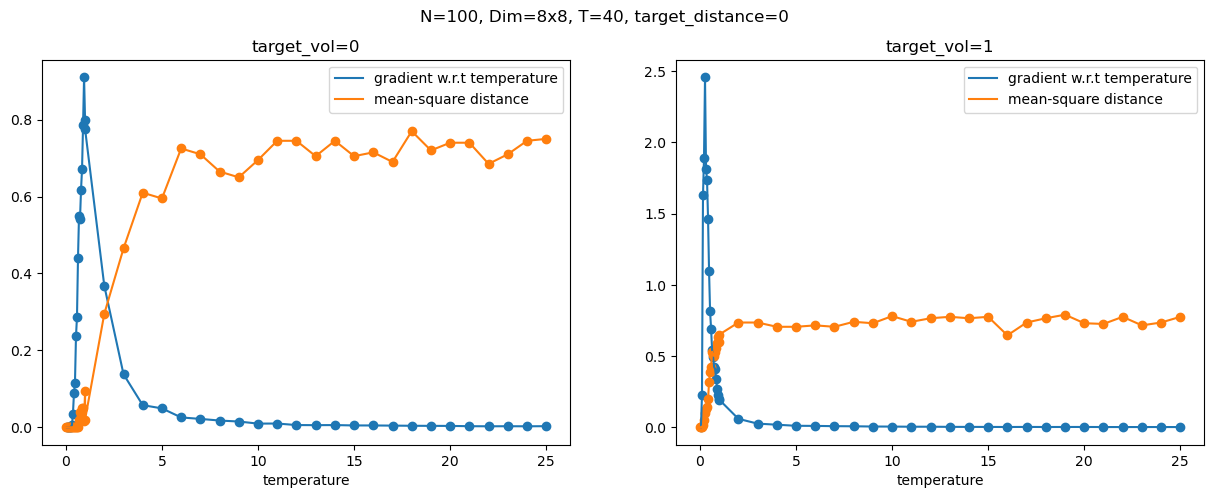

In [12]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].set(title="target_vol=1", xlabel="temperature")
axs[1].legend()

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0")
plt.show()


# Introduce Squared loss to target distance

In [13]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

## Num_steps = 40, 8x8 grid

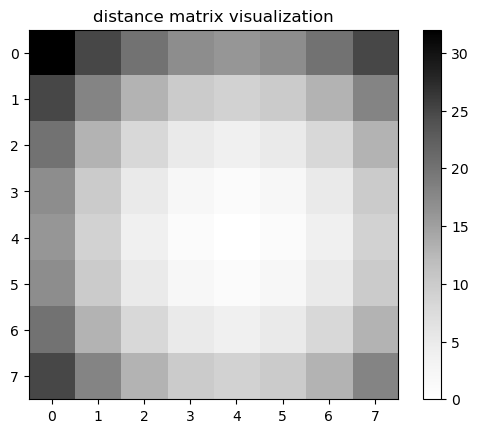

In [14]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [17]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 52.29it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 59.51it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 59.59it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 52.36it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 59.77it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 61.33it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 58.13it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 55.02it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 59.51it/s]


temperature: 0.42105263471603394, mean distance: 0.010000000000000002
gradient: 0.0016330668004229665


100%|██████████| 40/40 [00:00<00:00, 59.51it/s]


temperature: 0.4736842215061188, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 60.68it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 59.42it/s]


temperature: 0.5789473652839661, mean distance: 0.005
gradient: 0.0044900416396558285


100%|██████████| 40/40 [00:00<00:00, 59.51it/s]


temperature: 0.6315789222717285, mean distance: 0.010000000000000002
gradient: 0.00962209515273571


100%|██████████| 40/40 [00:00<00:00, 63.06it/s]


temperature: 0.6842105388641357, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 59.33it/s]


temperature: 0.7368420958518982, mean distance: 0.03000000000000001
gradient: 0.03792496770620346


100%|██████████| 40/40 [00:00<00:00, 59.07it/s]


temperature: 0.7894736528396606, mean distance: 0.025000000000000005
gradient: 0.03222830966114998


100%|██████████| 40/40 [00:00<00:00, 44.66it/s]


temperature: 0.8421052694320679, mean distance: 0.025000000000000005
gradient: 0.04352782294154167


100%|██████████| 40/40 [00:00<00:00, 49.82it/s]


temperature: 0.8947368264198303, mean distance: 0.05500000000000001
gradient: 0.07616482675075531


100%|██████████| 40/40 [00:00<00:00, 44.22it/s]


temperature: 0.9473684430122375, mean distance: 0.08500000000000002
gradient: 0.132619246840477


100%|██████████| 40/40 [00:00<00:00, 49.88it/s]


temperature: 1.0, mean distance: 0.05
gradient: 0.0686916708946228


100%|██████████| 40/40 [00:00<00:00, 58.04it/s]


temperature: 1.0, mean distance: 0.065
gradient: 0.09456393867731094


100%|██████████| 40/40 [00:00<00:00, 54.35it/s]


temperature: 2.0, mean distance: 0.385
gradient: 0.24663926661014557


100%|██████████| 40/40 [00:00<00:00, 53.48it/s]


temperature: 3.0, mean distance: 0.525
gradient: 0.13821472227573395


100%|██████████| 40/40 [00:00<00:00, 51.29it/s]


temperature: 4.0, mean distance: 0.655
gradient: 0.08789433538913727


100%|██████████| 40/40 [00:00<00:00, 52.09it/s]


temperature: 5.0, mean distance: 0.735
gradient: 0.04704556614160538


100%|██████████| 40/40 [00:00<00:00, 53.33it/s]


temperature: 6.0, mean distance: 0.73
gradient: 0.033285707235336304


100%|██████████| 40/40 [00:00<00:00, 54.79it/s]


temperature: 7.0, mean distance: 0.665
gradient: 0.028157003223896027


100%|██████████| 40/40 [00:00<00:00, 52.50it/s]


temperature: 8.0, mean distance: 0.72
gradient: 0.01786462590098381


100%|██████████| 40/40 [00:00<00:00, 52.56it/s]


temperature: 9.0, mean distance: 0.735
gradient: 0.02012726478278637


100%|██████████| 40/40 [00:00<00:00, 53.40it/s]


temperature: 10.0, mean distance: 0.63
gradient: 0.016001813113689423


100%|██████████| 40/40 [00:01<00:00, 37.98it/s]


temperature: 11.0, mean distance: 0.7
gradient: 0.013927833177149296


100%|██████████| 40/40 [00:00<00:00, 46.05it/s]


temperature: 12.0, mean distance: 0.715
gradient: 0.008935757912695408


100%|██████████| 40/40 [00:00<00:00, 50.26it/s]


temperature: 13.0, mean distance: 0.74
gradient: 0.008953983895480633


100%|██████████| 40/40 [00:00<00:00, 51.35it/s]


temperature: 14.0, mean distance: 0.755
gradient: 0.008140519261360168


100%|██████████| 40/40 [00:00<00:00, 52.22it/s]


temperature: 15.0, mean distance: 0.725
gradient: 0.007482255343347788


100%|██████████| 40/40 [00:00<00:00, 50.96it/s]


temperature: 16.0, mean distance: 0.775
gradient: 0.009871347807347775


100%|██████████| 40/40 [00:00<00:00, 52.84it/s]


temperature: 17.0, mean distance: 0.71
gradient: 0.006663710810244083


100%|██████████| 40/40 [00:00<00:00, 51.88it/s]


temperature: 18.0, mean distance: 0.71
gradient: 0.005264230538159609


100%|██████████| 40/40 [00:00<00:00, 48.97it/s]


temperature: 19.0, mean distance: 0.685
gradient: 0.0056747933849692345


100%|██████████| 40/40 [00:00<00:00, 50.77it/s]


temperature: 20.0, mean distance: 0.765
gradient: 0.005052728112787008


100%|██████████| 40/40 [00:00<00:00, 52.43it/s]


temperature: 21.0, mean distance: 0.7
gradient: 0.004610471893101931


100%|██████████| 40/40 [00:00<00:00, 52.98it/s]


temperature: 22.0, mean distance: 0.745
gradient: 0.004495332948863506


100%|██████████| 40/40 [00:00<00:00, 49.45it/s]


temperature: 23.0, mean distance: 0.71
gradient: 0.003825576277449727


100%|██████████| 40/40 [00:00<00:00, 44.86it/s]


temperature: 24.0, mean distance: 0.72
gradient: 0.0030769510194659233


100%|██████████| 40/40 [00:00<00:00, 51.09it/s]

temperature: 25.0, mean distance: 0.755
gradient: 0.003734372090548277


target_vol = 1, target_dist = 0

In [18]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 52.29it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 56.02it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 59.07it/s]


temperature: 0.10526315867900848, mean distance: 0.010000000000000002
gradient: 0.007631963584572077


100%|██████████| 40/40 [00:00<00:00, 57.62it/s]


temperature: 0.15789473056793213, mean distance: 0.005
gradient: 0.01736374758183956


100%|██████████| 40/40 [00:00<00:00, 57.30it/s]


temperature: 0.21052631735801697, mean distance: 0.04500000000000001
gradient: 0.22158481180667877


100%|██████████| 40/40 [00:00<00:00, 52.91it/s]


temperature: 0.2631579041481018, mean distance: 0.08000000000000002
gradient: 0.35039249062538147


100%|██████████| 40/40 [00:00<00:00, 49.27it/s]


temperature: 0.31578946113586426, mean distance: 0.10500000000000002
gradient: 0.42181655764579773


100%|██████████| 40/40 [00:00<00:00, 52.84it/s]


temperature: 0.3684210479259491, mean distance: 0.19
gradient: 0.5435608625411987


100%|██████████| 40/40 [00:00<00:00, 55.24it/s]


temperature: 0.42105263471603394, mean distance: 0.23
gradient: 0.5844120383262634


100%|██████████| 40/40 [00:00<00:00, 55.40it/s]


temperature: 0.4736842215061188, mean distance: 0.265
gradient: 0.6071074604988098


100%|██████████| 40/40 [00:00<00:00, 53.69it/s]


temperature: 0.5263158082962036, mean distance: 0.32
gradient: 0.5980789661407471


100%|██████████| 40/40 [00:00<00:00, 55.32it/s]


temperature: 0.5789473652839661, mean distance: 0.415
gradient: 0.5520361661911011


100%|██████████| 40/40 [00:00<00:00, 54.27it/s]


temperature: 0.6315789222717285, mean distance: 0.445
gradient: 0.5463847517967224


100%|██████████| 40/40 [00:00<00:00, 55.32it/s]


temperature: 0.6842105388641357, mean distance: 0.4800000000000001
gradient: 0.5227587223052979


100%|██████████| 40/40 [00:00<00:00, 55.09it/s]


temperature: 0.7368420958518982, mean distance: 0.52
gradient: 0.4635851979255676


100%|██████████| 40/40 [00:00<00:00, 52.29it/s]


temperature: 0.7894736528396606, mean distance: 0.565
gradient: 0.43055570125579834


100%|██████████| 40/40 [00:00<00:00, 53.76it/s]


temperature: 0.8421052694320679, mean distance: 0.56
gradient: 0.3620397746562958


100%|██████████| 40/40 [00:00<00:00, 54.13it/s]


temperature: 0.8947368264198303, mean distance: 0.615
gradient: 0.32323557138442993


100%|██████████| 40/40 [00:00<00:00, 46.47it/s]


temperature: 0.9473684430122375, mean distance: 0.5850000000000002
gradient: 0.3149314224720001


100%|██████████| 40/40 [00:00<00:00, 52.22it/s]


temperature: 1.0, mean distance: 0.615
gradient: 0.27190959453582764


100%|██████████| 40/40 [00:00<00:00, 50.96it/s]


temperature: 1.0, mean distance: 0.605
gradient: 0.2882024347782135


100%|██████████| 40/40 [00:00<00:00, 51.55it/s]


temperature: 2.0, mean distance: 0.68
gradient: 0.090556800365448


100%|██████████| 40/40 [00:00<00:00, 51.09it/s]


temperature: 3.0, mean distance: 0.73
gradient: 0.04849124699831009


100%|██████████| 40/40 [00:00<00:00, 51.82it/s]


temperature: 4.0, mean distance: 0.72
gradient: 0.02392805553972721


100%|██████████| 40/40 [00:00<00:00, 51.62it/s]


temperature: 5.0, mean distance: 0.72
gradient: 0.018371744081377983


100%|██████████| 40/40 [00:00<00:00, 51.62it/s]


temperature: 6.0, mean distance: 0.695
gradient: 0.013474168255925179


100%|██████████| 40/40 [00:00<00:00, 54.71it/s]


temperature: 7.0, mean distance: 0.755
gradient: 0.01017754152417183


100%|██████████| 40/40 [00:00<00:00, 51.22it/s]


temperature: 8.0, mean distance: 0.72
gradient: 0.008100977167487144


100%|██████████| 40/40 [00:00<00:00, 52.15it/s]


temperature: 9.0, mean distance: 0.75
gradient: 0.006846877280622721


100%|██████████| 40/40 [00:00<00:00, 51.03it/s]


temperature: 10.0, mean distance: 0.705
gradient: 0.006046873517334461


100%|██████████| 40/40 [00:00<00:00, 50.58it/s]


temperature: 11.0, mean distance: 0.77
gradient: 0.00607527419924736


100%|██████████| 40/40 [00:00<00:00, 51.68it/s]


temperature: 12.0, mean distance: 0.695
gradient: 0.003948337864130735


100%|██████████| 40/40 [00:00<00:00, 43.55it/s]


temperature: 13.0, mean distance: 0.755
gradient: 0.004402367398142815


100%|██████████| 40/40 [00:00<00:00, 51.62it/s]


temperature: 14.0, mean distance: 0.7600000000000001
gradient: 0.0043592676520347595


100%|██████████| 40/40 [00:00<00:00, 51.35it/s]


temperature: 15.0, mean distance: 0.745
gradient: 0.0031161902006715536


100%|██████████| 40/40 [00:00<00:00, 52.84it/s]


temperature: 16.0, mean distance: 0.8
gradient: 0.0031105466187000275


100%|██████████| 40/40 [00:00<00:00, 53.91it/s]


temperature: 17.0, mean distance: 0.75
gradient: 0.002843133406713605


100%|██████████| 40/40 [00:00<00:00, 50.90it/s]


temperature: 18.0, mean distance: 0.695
gradient: 0.002194552216678858


100%|██████████| 40/40 [00:00<00:00, 51.55it/s]


temperature: 19.0, mean distance: 0.74
gradient: 0.0025323713198304176


100%|██████████| 40/40 [00:00<00:00, 51.88it/s]


temperature: 20.0, mean distance: 0.7
gradient: 0.0017406512051820755


100%|██████████| 40/40 [00:00<00:00, 53.12it/s]


temperature: 21.0, mean distance: 0.815
gradient: 0.001685337396338582


100%|██████████| 40/40 [00:00<00:00, 51.42it/s]


temperature: 22.0, mean distance: 0.79
gradient: 0.0024635514710098505


100%|██████████| 40/40 [00:00<00:00, 51.09it/s]


temperature: 23.0, mean distance: 0.775
gradient: 0.0017992871580645442


100%|██████████| 40/40 [00:00<00:00, 53.55it/s]


temperature: 24.0, mean distance: 0.695
gradient: 0.0012204149970784783


100%|██████████| 40/40 [00:00<00:00, 50.58it/s]

temperature: 25.0, mean distance: 0.76
gradient: 0.001777208293788135


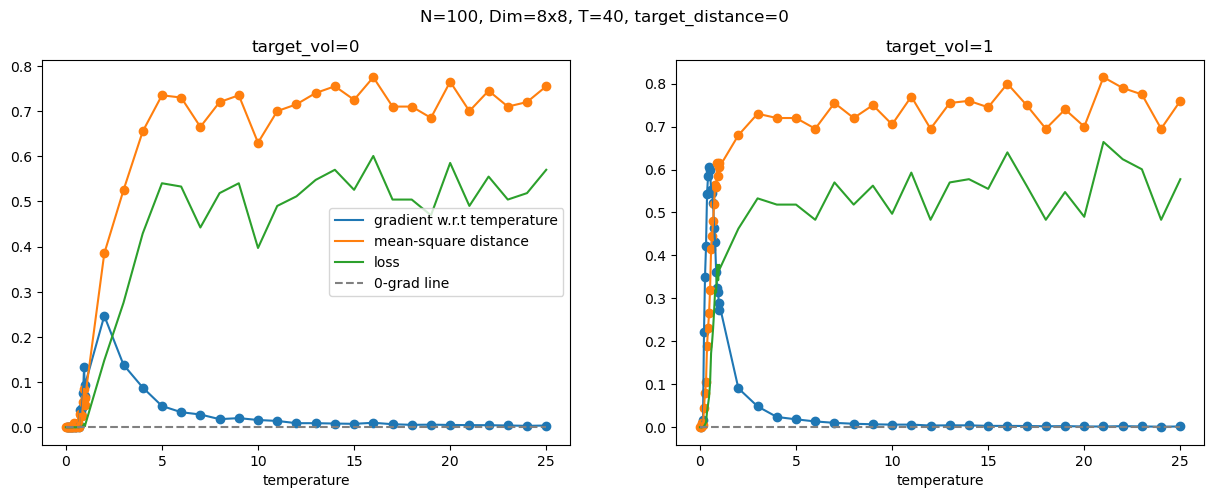

In [24]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0")
plt.show()


target_vol = 0, target_dist = 0.2

In [25]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 56.25it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 53.19it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -5.687082745752822e-29


100%|██████████| 40/40 [00:00<00:00, 44.37it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -4.051738870629318e-13


100%|██████████| 40/40 [00:00<00:00, 51.03it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: -2.7225752319282037e-08


100%|██████████| 40/40 [00:00<00:00, 48.85it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: -2.6009311113739386e-05


100%|██████████| 40/40 [00:00<00:00, 54.79it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: -0.0006428479100577533


100%|██████████| 40/40 [00:00<00:00, 49.58it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: -0.0021758079528808594


100%|██████████| 40/40 [00:00<00:00, 53.76it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: -0.017262598499655724


100%|██████████| 40/40 [00:00<00:00, 50.07it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: -0.020012142136693


100%|██████████| 40/40 [00:00<00:00, 55.86it/s]


temperature: 0.4736842215061188, mean distance: 0.010000000000000002
gradient: -0.05338485538959503


100%|██████████| 40/40 [00:00<00:00, 54.27it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: -0.07188696414232254


100%|██████████| 40/40 [00:00<00:00, 54.87it/s]


temperature: 0.5789473652839661, mean distance: 0.0
gradient: -0.14129850268363953


100%|██████████| 40/40 [00:00<00:00, 43.93it/s]


temperature: 0.6315789222717285, mean distance: 0.0
gradient: -0.13294261693954468


100%|██████████| 40/40 [00:00<00:00, 54.05it/s]


temperature: 0.6842105388641357, mean distance: 0.0
gradient: -0.21211884915828705


100%|██████████| 40/40 [00:00<00:00, 49.09it/s]


temperature: 0.7368420958518982, mean distance: 0.015
gradient: -0.22476273775100708


100%|██████████| 40/40 [00:00<00:00, 54.64it/s]


temperature: 0.7894736528396606, mean distance: 0.03
gradient: -0.20507223904132843


100%|██████████| 40/40 [00:00<00:00, 55.40it/s]


temperature: 0.8421052694320679, mean distance: 0.04
gradient: -0.22773036360740662


100%|██████████| 40/40 [00:00<00:00, 54.20it/s]


temperature: 0.8947368264198303, mean distance: 0.05500000000000002
gradient: -0.20508107542991638


100%|██████████| 40/40 [00:00<00:00, 54.49it/s]


temperature: 0.9473684430122375, mean distance: 0.04500000000000001
gradient: -0.2392939329147339


100%|██████████| 40/40 [00:00<00:00, 45.58it/s]


temperature: 1.0, mean distance: 0.06500000000000002
gradient: -0.20069754123687744


100%|██████████| 40/40 [00:00<00:00, 42.40it/s]


temperature: 1.0, mean distance: 0.06000000000000001
gradient: -0.18534432351589203


100%|██████████| 40/40 [00:00<00:00, 46.21it/s]


temperature: 2.0, mean distance: 0.305
gradient: 0.07144169509410858


100%|██████████| 40/40 [00:00<00:00, 48.97it/s]


temperature: 3.0, mean distance: 0.57
gradient: 0.09024655818939209


100%|██████████| 40/40 [00:00<00:00, 52.77it/s]


temperature: 4.0, mean distance: 0.64
gradient: 0.05576655641198158


100%|██████████| 40/40 [00:00<00:00, 52.50it/s]


temperature: 5.0, mean distance: 0.64
gradient: 0.033953145146369934


100%|██████████| 40/40 [00:00<00:00, 42.80it/s]


temperature: 6.0, mean distance: 0.705
gradient: 0.026716334745287895


100%|██████████| 40/40 [00:00<00:00, 48.09it/s]


temperature: 7.0, mean distance: 0.71
gradient: 0.019452307373285294


100%|██████████| 40/40 [00:00<00:00, 47.07it/s]


temperature: 8.0, mean distance: 0.74
gradient: 0.018800582736730576


100%|██████████| 40/40 [00:00<00:00, 42.94it/s]


temperature: 9.0, mean distance: 0.69
gradient: 0.014483141712844372


100%|██████████| 40/40 [00:00<00:00, 42.58it/s]


temperature: 10.0, mean distance: 0.75
gradient: 0.011212069541215897


100%|██████████| 40/40 [00:00<00:00, 51.75it/s]


temperature: 11.0, mean distance: 0.75
gradient: 0.00814749300479889


100%|██████████| 40/40 [00:00<00:00, 49.45it/s]


temperature: 12.0, mean distance: 0.755
gradient: 0.009115150198340416


100%|██████████| 40/40 [00:00<00:00, 46.05it/s]


temperature: 13.0, mean distance: 0.73
gradient: 0.0060446616262197495


100%|██████████| 40/40 [00:00<00:00, 47.92it/s]


temperature: 14.0, mean distance: 0.74
gradient: 0.0066599114798009396


100%|██████████| 40/40 [00:00<00:00, 44.91it/s]


temperature: 15.0, mean distance: 0.76
gradient: 0.006336925085633993


100%|██████████| 40/40 [00:00<00:00, 46.47it/s]


temperature: 16.0, mean distance: 0.755
gradient: 0.004842156078666449


100%|██████████| 40/40 [00:00<00:00, 46.91it/s]


temperature: 17.0, mean distance: 0.69
gradient: 0.0036724174860864878


100%|██████████| 40/40 [00:00<00:00, 43.27it/s]


temperature: 18.0, mean distance: 0.695
gradient: 0.003411072539165616


100%|██████████| 40/40 [00:00<00:00, 45.42it/s]


temperature: 19.0, mean distance: 0.735
gradient: 0.003489528317004442


100%|██████████| 40/40 [00:00<00:00, 49.95it/s]


temperature: 20.0, mean distance: 0.715
gradient: 0.003082087729126215


100%|██████████| 40/40 [00:00<00:00, 49.27it/s]


temperature: 21.0, mean distance: 0.735
gradient: 0.0030357385985553265


100%|██████████| 40/40 [00:00<00:00, 46.85it/s]


temperature: 22.0, mean distance: 0.73
gradient: 0.003350989893078804


100%|██████████| 40/40 [00:00<00:00, 51.22it/s]


temperature: 23.0, mean distance: 0.685
gradient: 0.0026120163965970278


100%|██████████| 40/40 [00:00<00:00, 42.99it/s]


temperature: 24.0, mean distance: 0.765
gradient: 0.003017023205757141


100%|██████████| 40/40 [00:00<00:00, 50.77it/s]

temperature: 25.0, mean distance: 0.735
gradient: 0.0026374980807304382


target_vol = 1, target_dist = 0.2

In [27]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 53.05it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 53.69it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -4.086366971023381e-05


100%|██████████| 40/40 [00:00<00:00, 60.58it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -0.1935490220785141


100%|██████████| 40/40 [00:00<00:00, 58.72it/s]


temperature: 0.15789473056793213, mean distance: 0.015000000000000003
gradient: -0.6042066216468811


100%|██████████| 40/40 [00:00<00:00, 52.50it/s]


temperature: 0.21052631735801697, mean distance: 0.015
gradient: -0.8233522772789001


100%|██████████| 40/40 [00:00<00:00, 59.59it/s]


temperature: 0.2631579041481018, mean distance: 0.05000000000000001
gradient: -0.7035506963729858


100%|██████████| 40/40 [00:00<00:00, 57.46it/s]


temperature: 0.31578946113586426, mean distance: 0.10000000000000002
gradient: -0.39774081110954285


100%|██████████| 40/40 [00:00<00:00, 58.55it/s]


temperature: 0.3684210479259491, mean distance: 0.2
gradient: 0.0


100%|██████████| 40/40 [00:00<00:00, 58.47it/s]


temperature: 0.42105263471603394, mean distance: 0.195
gradient: -0.012262298725545406


100%|██████████| 40/40 [00:00<00:00, 50.45it/s]


temperature: 0.4736842215061188, mean distance: 0.365
gradient: 0.319965660572052


100%|██████████| 40/40 [00:00<00:00, 46.80it/s]


temperature: 0.5263158082962036, mean distance: 0.35
gradient: 0.24265585839748383


100%|██████████| 40/40 [00:00<00:00, 56.33it/s]


temperature: 0.5789473652839661, mean distance: 0.39
gradient: 0.2610982358455658


100%|██████████| 40/40 [00:00<00:00, 55.09it/s]


temperature: 0.6315789222717285, mean distance: 0.4100000000000001
gradient: 0.2833921015262604


100%|██████████| 40/40 [00:00<00:00, 55.55it/s]


temperature: 0.6842105388641357, mean distance: 0.42
gradient: 0.27551984786987305


100%|██████████| 40/40 [00:00<00:00, 56.25it/s]


temperature: 0.7368420958518982, mean distance: 0.47
gradient: 0.2322179675102234


100%|██████████| 40/40 [00:00<00:00, 54.20it/s]


temperature: 0.7894736528396606, mean distance: 0.57
gradient: 0.26703834533691406


100%|██████████| 40/40 [00:00<00:00, 53.76it/s]


temperature: 0.8421052694320679, mean distance: 0.585
gradient: 0.20424777269363403


100%|██████████| 40/40 [00:00<00:00, 54.05it/s]


temperature: 0.8947368264198303, mean distance: 0.61
gradient: 0.2073296457529068


100%|██████████| 40/40 [00:00<00:00, 47.52it/s]


temperature: 0.9473684430122375, mean distance: 0.605
gradient: 0.22471779584884644


100%|██████████| 40/40 [00:00<00:00, 51.22it/s]


temperature: 1.0, mean distance: 0.56
gradient: 0.1789429634809494


100%|██████████| 40/40 [00:00<00:00, 54.57it/s]


temperature: 1.0, mean distance: 0.5850000000000002
gradient: 0.20327340066432953


100%|██████████| 40/40 [00:00<00:00, 51.29it/s]


temperature: 2.0, mean distance: 0.675
gradient: 0.053769852966070175


100%|██████████| 40/40 [00:00<00:00, 49.64it/s]


temperature: 3.0, mean distance: 0.755
gradient: 0.03643416985869408


100%|██████████| 40/40 [00:00<00:00, 51.09it/s]


temperature: 4.0, mean distance: 0.75
gradient: 0.02033315598964691


100%|██████████| 40/40 [00:00<00:00, 49.15it/s]


temperature: 5.0, mean distance: 0.725
gradient: 0.01355934888124466


100%|██████████| 40/40 [00:00<00:00, 51.68it/s]


temperature: 6.0, mean distance: 0.75
gradient: 0.011615507304668427


100%|██████████| 40/40 [00:00<00:00, 51.22it/s]


temperature: 7.0, mean distance: 0.77
gradient: 0.008730681613087654


100%|██████████| 40/40 [00:00<00:00, 52.91it/s]


temperature: 8.0, mean distance: 0.68
gradient: 0.00559831690043211


100%|██████████| 40/40 [00:00<00:00, 53.98it/s]


temperature: 9.0, mean distance: 0.74
gradient: 0.006078243255615234


100%|██████████| 40/40 [00:00<00:00, 51.68it/s]


temperature: 10.0, mean distance: 0.72
gradient: 0.005205672699958086


100%|██████████| 40/40 [00:00<00:00, 51.95it/s]


temperature: 11.0, mean distance: 0.725
gradient: 0.003605116857215762


100%|██████████| 40/40 [00:00<00:00, 52.36it/s]


temperature: 12.0, mean distance: 0.8000000000000002
gradient: 0.0035669526550918818


100%|██████████| 40/40 [00:00<00:00, 45.94it/s]


temperature: 13.0, mean distance: 0.735
gradient: 0.002908566268160939


100%|██████████| 40/40 [00:00<00:00, 52.63it/s]


temperature: 14.0, mean distance: 0.765
gradient: 0.002549726516008377


100%|██████████| 40/40 [00:00<00:00, 51.88it/s]


temperature: 15.0, mean distance: 0.75
gradient: 0.0025368633214384317


100%|██████████| 40/40 [00:00<00:00, 51.22it/s]


temperature: 16.0, mean distance: 0.76
gradient: 0.002259214408695698


100%|██████████| 40/40 [00:00<00:00, 52.91it/s]


temperature: 17.0, mean distance: 0.79
gradient: 0.0028390437364578247


100%|██████████| 40/40 [00:00<00:00, 50.51it/s]


temperature: 18.0, mean distance: 0.775
gradient: 0.002045900095254183


100%|██████████| 40/40 [00:00<00:00, 53.26it/s]


temperature: 19.0, mean distance: 0.795
gradient: 0.002417950192466378


100%|██████████| 40/40 [00:00<00:00, 51.68it/s]


temperature: 20.0, mean distance: 0.7700000000000001
gradient: 0.0018475668039172888


100%|██████████| 40/40 [00:00<00:00, 52.22it/s]


temperature: 21.0, mean distance: 0.73
gradient: 0.0013966300757601857


100%|██████████| 40/40 [00:00<00:00, 51.68it/s]


temperature: 22.0, mean distance: 0.72
gradient: 0.0012880656868219376


100%|██████████| 40/40 [00:00<00:00, 55.47it/s]


temperature: 23.0, mean distance: 0.73
gradient: 0.0010535020846873522


100%|██████████| 40/40 [00:00<00:00, 53.05it/s]


temperature: 24.0, mean distance: 0.74
gradient: 0.0011610721703618765


100%|██████████| 40/40 [00:00<00:00, 50.77it/s]

temperature: 25.0, mean distance: 0.785
gradient: 0.001381312613375485


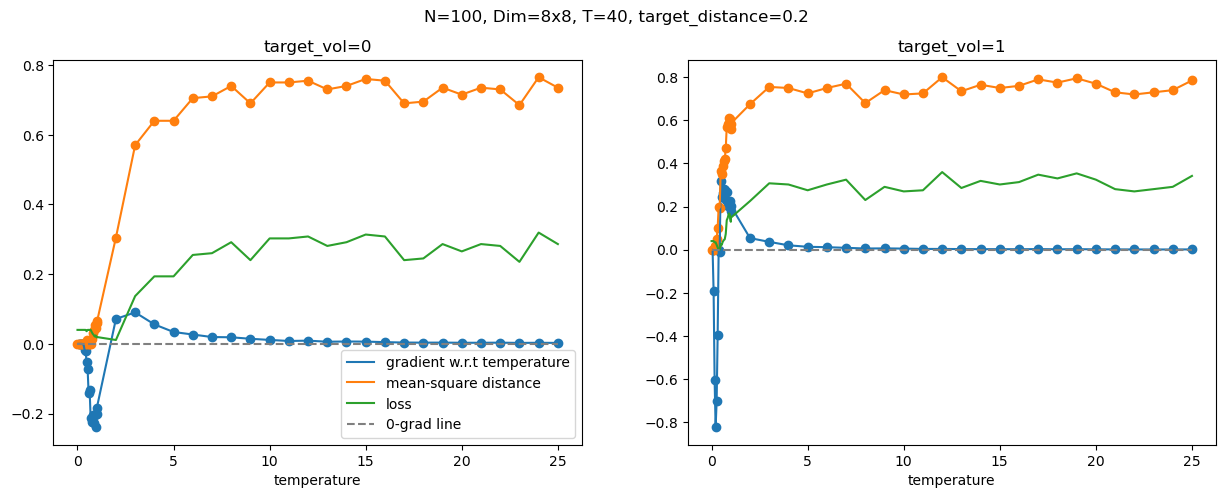

In [28]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.2")
plt.show()
